# BackPropagation ( CSE-URP 이승한 )

## 목표
- BackPropagation 구현하기
- Input Layer 2개, Hidden Layer 7개, OutputLayer 2개
- hyperparameter : epochs=16

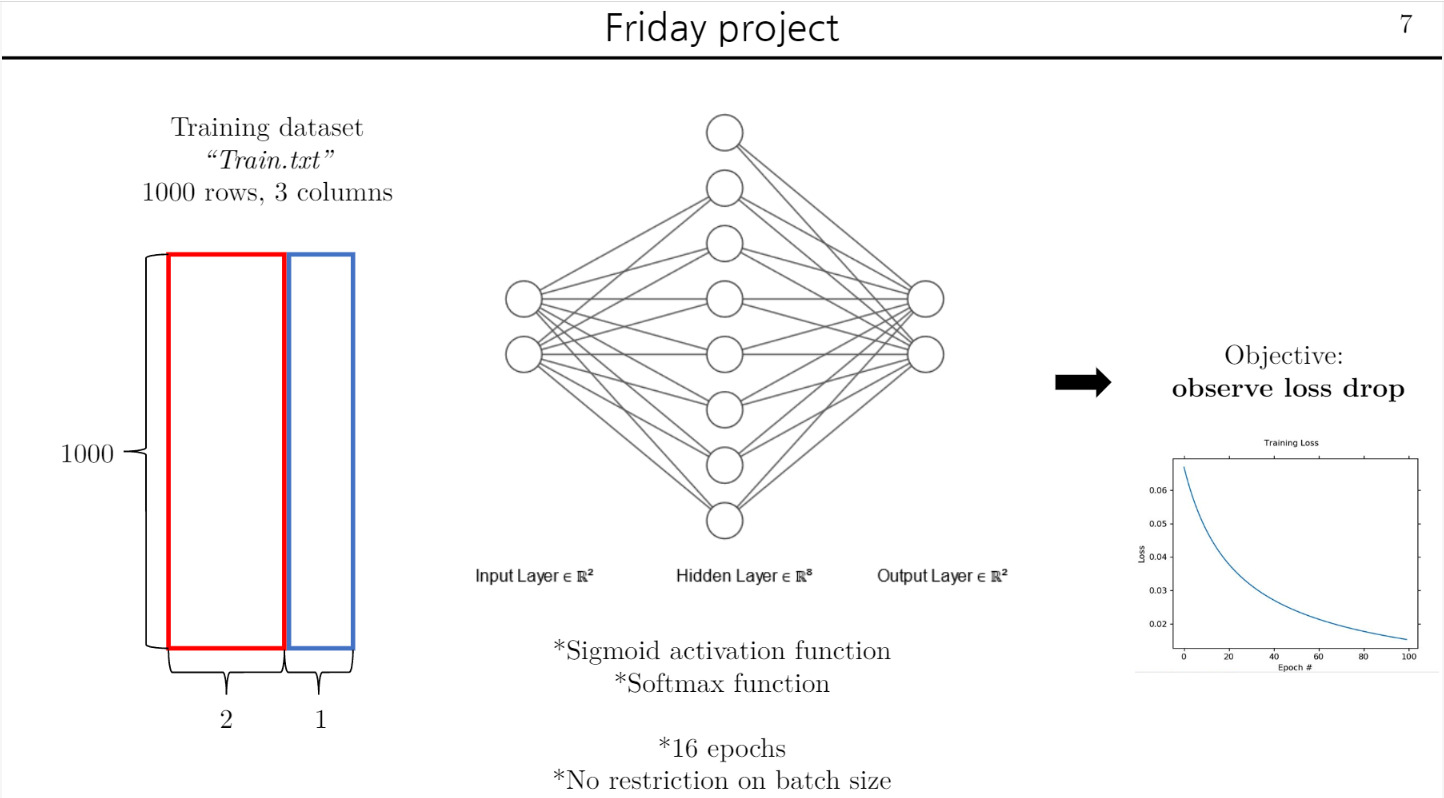

# 1. Importing libraries & dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = np.loadtxt('train.txt')

In [3]:
np.random.shuffle(data)

In [4]:
print(data.shape)
data

(1000, 3)


array([[14.85418  , 10.31827  ,  0.       ],
       [20.981027 ,  3.4718131,  0.       ],
       [19.83997  , 10.857203 ,  0.       ],
       ...,
       [13.025853 ,  9.9031394,  1.       ],
       [ 6.3606368, 10.563107 ,  1.       ],
       [ 7.3325119, 12.256012 ,  1.       ]])

In [5]:
data_ = np.column_stack((data,1-data[:,2]))

In [6]:
X = data[:,:2]
y = data[:,-1:]

In [7]:
X2 = data_[:,:2]
y2 = data_[:,-2:]

In [8]:
X2

array([[14.85418  , 10.31827  ],
       [20.981027 ,  3.4718131],
       [19.83997  , 10.857203 ],
       ...,
       [13.025853 ,  9.9031394],
       [ 6.3606368, 10.563107 ],
       [ 7.3325119, 12.256012 ]])

# 2. Basic Functions
- transpose
- matrix multiplication

In [9]:
def _t(X):
    return np.transpose(X)

def _m(A,B):
    return np.matmul(A,B)

- (activation function) sigmoid / ReLU & softmax

In [10]:
class Sigmoid:
    def __init__(self):
        self.last_o = 1
    
    def __call__(self,X):
        self.last_o = 1/(1+np.exp(-X))
        return self.last_o
    
    def grad(self):
        return self.last_o*(1-self.last_o)

In [11]:
class ReLU:
    def __init__(self):
        self.last_o = 1
        
    def __call__(self,X):
        self.last_o = np.maximum(0,X)
        return self.last_o
    
    def grad(self):
        return np.where(self.last_o>0,1,0)

In [12]:
class Softmax:
    def __init__(self):
        self.last_o = 1
        
    def __call__(self,X):
        e_x = np.exp(X-np.max(X))
        self.last_o = e_x / e_x.sum()
        return self.last_o
    
    def grad(self):
        return self.last_o*(1-self.last_o)

- (loss function) MSE

In [13]:
class MSE:
    def __init__(self):
        self.dh = 1
        self.last_diff = 1
    
    def __call__(self,y,yhat):
        self.last_diff = y-yhat
        mse = 1/2*np.mean(np.square(y-yhat))
        return mse
    
    def grad(self):
        return self.last_diff

# 3. Network Architecture

### 1) Neuron

In [14]:
class Neuron :
    def __init__(self,W,b,activation):
        self.W = W
        self.b = b
        self.act= activation()
        
        self.dW = np.zeros_like(self.W)  
        self.db = np.zeros_like(self.b)
        self.dh = np.zeros_like(_t(self.W)) # h =WT*X + b
        
        self.last_x = np.zeros((self.W.shape[0])) # to calculate grad_W, save the input(x)
        self.last_h = np.zeros((self.W.shape[1]))
        
    def __call__(self,x):
        self.last_x = x
        self.last_h = _m(_t(self.W),x) + self.b
        output = self.act(self.last_h)
        return output
    
    def grad(self): 
        grad = self.act.grad()*self.W
        return grad
    
    # let < u = WX+b > & < h = f(u) >
    def grad_W(self,dh): # dh/dW = dh/du * du/dW
        grad = np.ones_like(self.W) 
        grad_a = self.act.grad()   # dh/du     
        for j in range(grad.shape[1]):
            grad[:,j] = dh[j] * grad_a[j] * self.last_x     # previous gradient * dh/du * du/dW
        return grad
        
    def grad_b(self,dh) : # dh/db = dh/du * du/db
        grad = dh * self.act.grad() * 1  # previous gradient * dh/du * du/db
        return grad

### 2) Neural Network

In [15]:
class NN:
    def __init__(self,input_num,output_num,  # 1) number of input &  2) number of output
                 hidden_depth,num_neuron, # 3) number of hidden layers & 4) neurons per layer
                 activation=Sigmoid, activation2=Softmax): # 5) 6) activation function
        def init_var(in_,out_):
            weight = np.random.normal(0,0.01,(in_,out_))
            bias = np.zeros((out_,))
            return weight,bias
           
    ## 1-1. Hidden Layer
        self.sequence = list() # lists to put neurons
        W,b = init_var(input_num,num_neuron)
        self.sequence.append(Neuron(W,b,activation)) # b ->0 ( no bias term in input-hidden layer )
    
        if hidden_depth>1 : # DNN
            for _ in range(hidden_depth-1):
                W,b = init_var(num_neuron,num_neuron)
                self.sequence.append(Neuron(W,b,activation)) # default : Sigmoid
    
    ## 1-2. Output Layer
        W,b = init_var(num_neuron,output_num)
        self.sequence.append(Neuron(W,b,activation2)) # default : Softmax
    
    def __call__(self,x):
        for layer in self.sequence:
            x = layer(x)
        return x
    
    def calc_grad(self,loss_fun):
        loss_fun.dh = loss_fun.grad()
        self.sequence.append(loss_fun)
        
        for i in range(len(self.sequence)-1, 0, -1):
            L1 = self.sequence[i]
            L0 = self.sequence[i-1]
            
            L0.dh = _m(L0.grad(), L1.dh)
            L0.dW = L0.grad_W(L1.dh)
            L0.db = L0.grad_b(L1.dh)
            
        self.sequence.remove(loss_fun)   

# 4. Gradient Descent

In [16]:
def GD(nn,x,y,loss_fun,lr=0.01):
    loss = loss_fun(nn(x),y) # 1) FEED FORWARD
    nn.calc_grad(loss_fun) # 2) BACK PROPAGATION
    
    for layer in nn.sequence: # Update Equation
        layer.W += -lr*layer.dW
        layer.b += -lr*layer.db    
    return loss

# 5. Implement BackPropagation 

In [17]:
NeuralNet = NN(2,2,1,7)
loss_fun = MSE()
EPOCH = 16

In [18]:
loss_per_epoch = []
for epoch in range(EPOCH):
    for i in range(X2.shape[0]):
        loss = GD(NeuralNet,X2[i],y2[i],loss_fun,0.01)
    loss_per_epoch.append(loss)
    print('Epoch {} : Loss {}'.format(epoch+1, loss))

Epoch 1 : Loss 0.18218546700245103
Epoch 2 : Loss 0.1699588665083517
Epoch 3 : Loss 0.1317847633702473
Epoch 4 : Loss 0.0871812251857476
Epoch 5 : Loss 0.055367214705294654
Epoch 6 : Loss 0.036283073852796305
Epoch 7 : Loss 0.025060430768749416
Epoch 8 : Loss 0.01822353886098449
Epoch 9 : Loss 0.013846415453448049
Epoch 10 : Loss 0.010904192049834446
Epoch 11 : Loss 0.008839350381845591
Epoch 12 : Loss 0.007335897223110011
Epoch 13 : Loss 0.0062065922468843215
Epoch 14 : Loss 0.005335701415371787
Epoch 15 : Loss 0.004648900081571788
Epoch 16 : Loss 0.0040968068434452136


# 6. Error

Text(0.5, 1.0, 'Shallow NN')

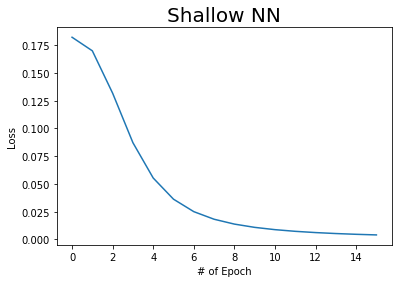

In [19]:
plt.plot(loss_per_epoch)
plt.xlabel('# of Epoch')
plt.ylabel('Loss')
plt.title('Shallow NN',fontsize=20)

In [20]:
import pandas as pd

In [21]:
df = pd.DataFrame(data)
df.columns = ['X1','X2','Actual']
predicted = [np.round(NeuralNet(data[i][0:2]),0)[0] for i in range(1000)]
df['Predicted'] = predicted

In [22]:
df.head(20)

,X1,X2,Actual,Predicted
0,14.854180,10.318270,0.0,0.0
1,20.981027,3.471813,0.0,0.0
2,19.839970,10.857203,0.0,0.0
3,13.718387,11.454695,1.0,1.0
4,14.861047,9.397070,0.0,0.0
5,21.432007,8.127898,0.0,0.0
6,11.596633,9.323756,1.0,0.0
7,21.997120,5.121064,0.0,0.0
8,14.031759,4.340100,0.0,0.0
9,12.198730,10.474550,1.0,1.0


Text(0.5, 1.0, 'Actual Class')

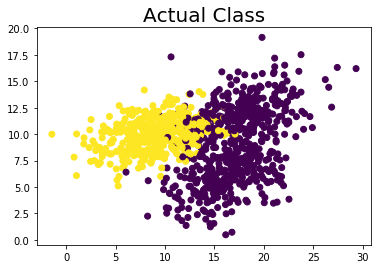

In [23]:
plt.scatter(df['X1'], df['X2'], c=df['Actual'])
plt.title("Actual Class", fontsize=20)

Text(0.5, 1.0, 'Predicted Class')

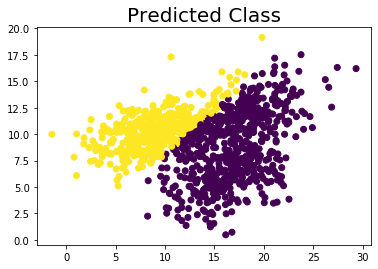

In [24]:
plt.scatter(df['X1'], df['X2'], c=df['Predicted'])
plt.title("Predicted Class", fontsize=20)

### Layer를 1개만 쌓아서 

# [추가] 

- Acitvation function을 Sigmoid 대신 ReLU로,
- Hidden Layer를 1개 대신 여러 개로 (DNN) 만들 수 있다

### EX) 
- activation function : ReLU
- number of hidden layers : 3
- number of nodes in one hidden layers : 4

In [47]:
NeuralNet2 = NN(2,2,3,4,activation=ReLU)
loss_fun = MSE()
EPOCH = 16

In [48]:
loss_per_epoch2 = []
for epoch in range(EPOCH):
    for i in range(X2.shape[0]):
        loss = GD(NeuralNet2,X2[0],y2[0],loss_fun,0.01)
    loss_per_epoch2.append(loss)
    print('Epoch {} : Loss {}'.format(epoch+1, loss))

Epoch 1 : Loss 0.0024158587895954558
Epoch 2 : Loss 0.001027153615391233
Epoch 3 : Loss 0.0006425978569413866
Epoch 4 : Loss 0.00046523067973551046
Epoch 5 : Loss 0.00036374133584255537
Epoch 6 : Loss 0.00029820837128012546
Epoch 7 : Loss 0.0002524756861422122
Epoch 8 : Loss 0.00021878345054632167
Epoch 9 : Loss 0.00019294880735867928
Epoch 10 : Loss 0.00017252085371608517
Epoch 11 : Loss 0.00015596965442570948
Epoch 12 : Loss 0.00014229145060395038
Epoch 13 : Loss 0.00013080070123516405
Epoch 14 : Loss 0.00012101342499682807
Epoch 15 : Loss 0.00011257830292046774
Epoch 16 : Loss 0.00010523420412829551


Text(0.5, 1.0, 'Deep NN with 5 hidden layers & ReLU')

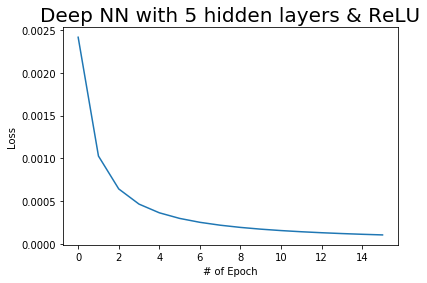

In [49]:
plt.plot(loss_per_epoch2)
plt.xlabel('# of Epoch')
plt.ylabel('Loss')
plt.title('Deep NN with 5 hidden layers & ReLU',fontsize=20)